In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.anova import AnovaRM
import pylab

In [76]:
plant_biomass = pd.read_excel('../Data/Plant biomass/Akron 2021 NxIrr Biomass by date summary.xlsx', engine='openpyxl')
plant_biomass['Date'] = pd.to_datetime(plant_biomass['Date'])
plant_biomass['TrtID'] = plant_biomass['TrtID'].astype('str')
plant_biomass['Nitrogen'] = [x[-1] for x in plant_biomass['TrtID']]
plant_biomass['Water'] = [x[1] for x in plant_biomass['TrtID']]
plant_biomass['Date simple'] = [x.strftime('%m-%d') for x in plant_biomass['Date']]
plant_biomass['Nitrogen_numeric'] = pd.to_numeric(plant_biomass['Nitrogen'])
plant_biomass['Nitrogen_numeric'] = plant_biomass['Nitrogen_numeric'].replace({1.0: 20, 2.0: 65, 3.0:110, 4.0:155, 5.0:200, 6.0:245})
# Non-log data is not normal and qqplot is no good --- this is for all of it
# Normal for grain
plant_biomass['Biomass'] = plant_biomass['Dry weight (per plant), g']
plant_biomass['DW_log'] = np.log(plant_biomass['Dry weight (per plant), g'])
plant_biomass['Water'] = plant_biomass['Water'].replace({'1': '100', '2': '70'})
plant_biomass.head()

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Plot,PlantPart,"Dry weight (5 plants), g","Dry weight (per plant), g",TrtID,DatePartTrtID,Unnamed: 7,Unnamed: 8,Plot.1,TRTID,Nitrogen,Water,Date simple,Nitrogen_numeric,Biomass,DW_log
0,2021-09-23,1,Leaves,162.0,32.4,114,44462Leaves114,NaN,NaN,1.0,114.0,4,100,09-23,155,32.4,3.478158
1,2021-09-23,2,Leaves,135.0,27.0,111,44462Leaves111,NaN,NaN,2.0,111.0,1,100,09-23,20,27.0,3.295837
2,2021-09-23,3,Leaves,158.0,31.6,115,44462Leaves115,NaN,NaN,3.0,115.0,5,100,09-23,200,31.6,3.453157
3,2021-09-23,4,Leaves,206.0,41.2,113,44462Leaves113,NaN,NaN,4.0,113.0,3,100,09-23,110,41.2,3.718438
4,2021-09-23,5,Leaves,199.0,39.8,112,44462Leaves112,NaN,NaN,5.0,112.0,2,100,09-23,65,39.8,3.683867


In [77]:
set(plant_biomass['Date simple'])

{'06-09', '06-30', '07-21', '08-04', '09-23'}

(0.0, 200.0)

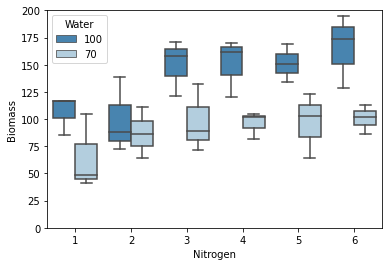

In [85]:
plotting_data = plant_biomass[plant_biomass['PlantPart'] == 'Grain']
sns.boxplot(y = 'Biomass', x = 'Nitrogen', hue = 'Water', data = plotting_data, palette = 'Blues_r',
           order = ['1','2','3','4','5','6'])
plt.ylim([0,200])
# sns.lineplot(y = 'Biomass', x = 'Date', hue = 'Nitrogen',
#              hue_order = ['1','2','3','4','5','6'], data = plotting_data)
# plt.xticks(rotation = 'vertical')

(0.0, 200.0)

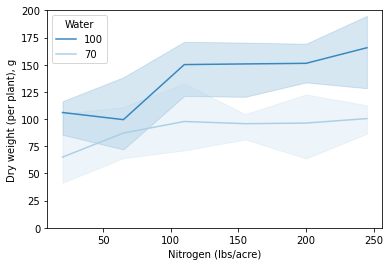

In [88]:
sns.lineplot(y = 'Biomass', x = 'Nitrogen_numeric', hue = 'Water', data = plotting_data, palette='Blues_r')
plt.ylabel('Dry weight (per plant), g')
plt.xlabel('Nitrogen (lbs/acre)')
plt.ylim([0,200])

# Check for assumptions

In [57]:
# normality test
# Plot residuals
stat, p = shapiro(plant_biomass[plant_biomass['PlantPart'] == 'Grain']['Dry weight (per plant), g'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.979, p=0.700
Sample looks Gaussian (fail to reject H0)


In [33]:
# normality test
# Plot residuals
stat, p = shapiro(plant_biomass['DW_log'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


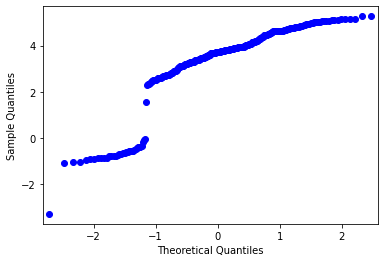

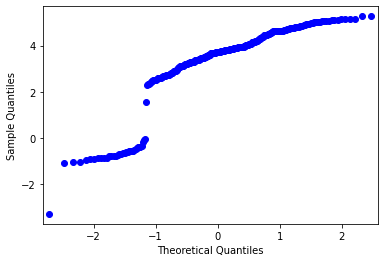

In [38]:
# This looks weird
sm.qqplot(plant_biomass['DW_log'], line = 's')

# ANOVA

In [42]:
plant_biomass.columns.values

array(['Date', 'Plot', 'PlantPart', 'Dry weight (5 plants), g',
       'Dry weight (per plant), g', 'TrtID', 'DatePartTrtID',
       'Unnamed: 7', 'Unnamed: 8', 'Plot.1', 'TRTID', 'Nitrogen', 'Water',
       'Date simple', 'DW_log'], dtype=object)

In [47]:
print(set(plant_biomass['PlantPart']))
plant_biomass['PlantPart'].value_counts()

{'Grain', 'Shoots', 'Leaves', 'Cobs', 'Stalks'}


Stalks    78
Leaves    78
Shoots    72
Cobs      36
Grain     36
Name: PlantPart, dtype: int64

In [41]:
plant_biomass['Date'].value_counts()

2021-09-23    144
2021-08-04     72
2021-06-30     36
2021-06-09     36
2021-07-21     12
Name: Date, dtype: int64

In [53]:
plant_biomass[plant_biomass['PlantPart'] == 'Shoots']['Date'].value_counts()

2021-06-09    36
2021-06-30    36
Name: Date, dtype: int64

In [50]:
model = AnovaRM(plant_biomass[plant_biomass['PlantPart'] == 'Shoots'], 'DW_log', 'Date', within = ['Nitrogen','Water'], aggregate_func='mean')
results = model.fit()
print(results)

                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
Nitrogen        1.9668 5.0000 5.0000 0.2378
Water           0.2404 1.0000 1.0000 0.7098
Nitrogen:Water  0.3145 5.0000 5.0000 0.8850



In [51]:
plant_biomass[plant_biomass['PlantPart'] == 'Grain']['Date'].value_counts()

2021-09-23    36
Name: Date, dtype: int64

In [52]:
model = ols('DW_log ~ C(Nitrogen) + C(Water) + C(Nitrogen):C(Water)', data=plant_biomass[plant_biomass['PlantPart'] == 'Grain']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Nitrogen),1.099549,5.0,3.132178,0.025732
C(Water),1.635565,1.0,23.295377,0.000065
C(Nitrogen):C(Water),0.183507,5.0,0.522740,0.756633
Residual,1.685036,24.0,NaN,NaN
